In [1]:
def fetch(url: str):
    """
    Makes an HTTP request and returns the HTML
    param url: URL of the news article being analyzed
    """
    
    headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                              "AppleWebKit/537.36 (KHTML, like Gecko) "
                              "Chrome/120.0.0.0 Safari/537.36",
                "Accept-Language": "pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7",
            }
    req = requests.get(url_sp, headers=headers)
    if req.status_code == 200:
        print('Request Successful!')
        content = req.content
    else:
        print('Request Failed!')
        content = None
    return content

def parse(content: str):
    soup = BeautifulSoup(content, 'html.parser')
    return soup

In [2]:
import re
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.diagnostic import het_arch
from numpy.random import choice

In [3]:
#url_sp = "https://finance.yahoo.com/quote/%5EGSPC/history/?period1=-1325583000&period2=1766028839"

#content_sp = fetch(url_sp)

In [4]:
# Requisição falha, buscar via Selenium com Firefox
# The request failed, trying with Selenium

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary

binary = FirefoxBinary('C:\\Program Files\\Mozilla Firefox\\firefox.exe')
driver = webdriver.Firefox(firefox_binary=binary, executable_path = r'C:\\geckodriver.exe')
wait = WebDriverWait(driver, 10)

C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\267000086.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(firefox_binary=binary, executable_path = r'C:\\geckodriver.exe')
C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\267000086.py:11: DeprecationWarning: firefox_binary has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(firefox_binary=binary, executable_path = r'C:\\geckodriver.exe')


In [5]:
driver.get("https://br.investing.com/indices/us-spx-500-historical-data")

In [6]:
# Seletor CSS do ad (se houver)

try:
    button = driver.find_element(By.CSS_SELECTOR, ".float-end")
    button.click()
except:
    print('There is no ads in the page')

There is no ads in the page


In [7]:
# Seletor CSS do dropbox com periodicidade dos dados
# CSS Selector of the dropbox with the data periodicity

button = driver.find_element(By.CSS_SELECTOR, "#__next > div.md\:relative.md\:bg-white > div.relative.flex > div.grid.flex-1.grid-cols-1.px-4.pt-6.font-sans-v2.text-\[\#232526\].antialiased.transition-all.xl\:container.sm\:px-6.sm\:pt-8.md\:gap-6.md\:px-7.md\:pt-10.md2\:gap-8.md2\:px-8.xl\:mx-auto.xl\:gap-10.xl\:px-10.md\:grid-cols-\[1fr_72px\].md2\:grid-cols-\[1fr_420px\] > div.min-w-0 > div.mb-4.md\:mb-10 > div.sm\:flex.sm\:items-end.sm\:justify-between > div.mb-\[23px\].flex.flex-col.gap-3.sm\:mb-0 > div.historical-data-v2_selection-arrow__3mX7U.relative.flex.flex-1.items-center.justify-start.gap-1.rounded.border.border-solid.border-\[\#CFD4DA\].bg-white.bg-select-custom.px-3.py-2.text-sm.leading-5.text-\[\#333\].shadow-select.sm\:w-\[210px\]")
button.click()

In [8]:
# Clicando na opção "Mensal"
# Clicking in "Mensal"

period = wait.until(
    EC.element_to_be_clickable((By.CSS_SELECTOR, "div.historical-data-v2_menu-row__oRAlf:nth-child(3) > span:nth-child(1)"))
)
period.click()

In [9]:
# Definindo datas a serem pegas
# Defining the dates

button_calendar = driver.find_element(By.CSS_SELECTOR,"div.text-\[\#333\]:nth-child(1)")
button_calendar.click()

In [10]:
# inclui dia, mes e ano
# data setada: 1995

# send the day, month and year
# date: 1995

data = driver.find_element(By.CSS_SELECTOR,"div.NativeDateInputV2_root__uAIu0:nth-child(1) > input:nth-child(2)")
data.clear()
data.send_keys("1995-01-01")

In [11]:
# botão de aplicar o filtro
# Applying the filter

driver.find_element(By.CSS_SELECTOR,".bg-v2-blue").click()

In [12]:
# puxa tabela (houve problema ao ler a tabela por conta do formato br dos numeros)
# getting the table

time.sleep(10)
tab = driver.find_element(By.CSS_SELECTOR, ".freeze-column-w-1")
html_tab = tab.get_attribute("outerHTML")
df_sp = pd.read_html(html_tab)[0]
df_sp = df_sp.astype(str)
df_sp = df_sp[['Data','Último']]
df_sp.head()

,Data,Último
0,01.12.2025,"6.833,23"
1,01.11.2025,"6.849,09"
2,01.10.2025,"6.840,20"
3,01.09.2025,"6.688,46"
4,01.08.2025,"6.460,26"


In [13]:
soup = BeautifulSoup(html_tab, "html.parser")

data = []
for row in soup.select("tr"):
    cols = [td.get_text(strip=True) for td in row.select("td")]
    if cols:
        data.append(cols)

df_sp = pd.DataFrame(data)
df_sp = df_sp.iloc[:,[0,1]]
df_sp.columns=['date','price']
df_sp.head()

,date,price
0,01.12.2025,"6.833,23"
1,01.11.2025,"6.849,09"
2,01.10.2025,"6.840,20"
3,01.09.2025,"6.688,46"
4,01.08.2025,"6.460,26"


In [14]:
df_sp['date'] = pd.to_datetime(df_sp['date'].apply(lambda x: f'{x[6:]}-{x[3:5]}-{x[:2]}'))
df_sp['price'] = df_sp['price'].str.replace('.','').str.replace(',','.').astype(float)

In [15]:
df_sp.head()

,date,price
0,2025-12-01,6833.23
1,2025-11-01,6849.09
2,2025-10-01,6840.20
3,2025-09-01,6688.46
4,2025-08-01,6460.26


In [17]:
# dados sunspot
# a quarta coluna é a desejada: monthly mean number of sunspots

# sunspots data
# the forth column is the monthly mean number of sunspots

df_sun = pd.read_csv('C:\projeto\desafio-analise-quant\SN_m_tot.csv',sep=";",header=None)
df_sun = df_sun[[0,1,3]]
df_sun.columns = ['year','month','mean_sunspots']
df_sun = df_sun[df_sun['year']>=1995]
df_sun.head()

,year,month,mean_sunspots
2952,1995,1,32.6
2953,1995,2,45.8
2954,1995,3,46.3
2955,1995,4,21.6
2956,1995,5,19.4


In [18]:
# checking the size

df_sun.shape

(371, 3)

In [19]:
# transforming to datetime format

df_sun['date'] = pd.to_datetime(
    dict(year=df_sun['year'], month=df_sun['month'], day=1)
)
df_sun = df_sun[['date','mean_sunspots']]

In [20]:
df_sun.head()

,date,mean_sunspots
2952,1995-01-01,32.6
2953,1995-02-01,45.8
2954,1995-03-01,46.3
2955,1995-04-01,21.6
2956,1995-05-01,19.4


In [21]:
df_group = df_sun.merge(df_sp[['date','price']], on='date',how='left')
df_group = df_group.sort_values('date',ascending=False)

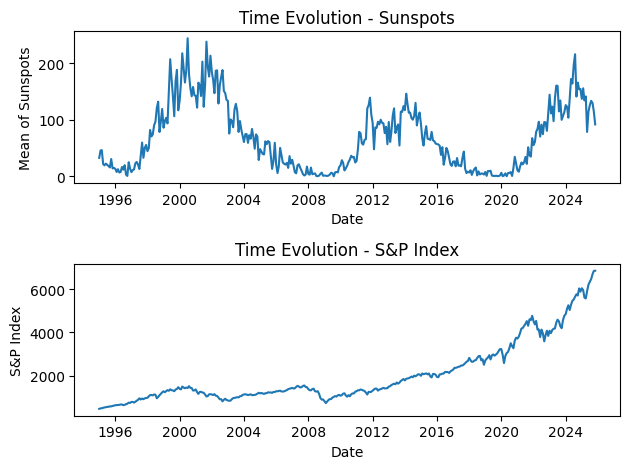

In [22]:
plt.subplot(2,1,1)
sns.lineplot(data = df_group, y = 'mean_sunspots', x = 'date')
plt.title('Time Evolution - Sunspots')
plt.xlabel('Date')
plt.ylabel('Mean of Sunspots')
plt.subplot(2,1,2)
sns.lineplot(data = df_group, y = 'price', x = 'date')
plt.title('Time Evolution - S&P Index')
plt.ylabel('S&P Index')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("temporal_evolution_series.png")

# (About the Temporal Evolution) Sobre a Evolução Temporal:

## S&P 500 Index

A evolução temporal é um processo estocástico com tendência sem sazonalidade.
Precisamos torná-las estacionárias (e homocedásticas, se possível) para realizar a validação cruzada.

The temporal evolution of S&P 500 Index is a stochastic process with a trend but no seasonality.
We need to make the series stationary (and homoscedastic, if possible) in order to perform cross-validation

## Mean of Sunspots

A evolução temporal caracteriza-se por, aparentemente, ser um processo estacionário sazonal (não há tendência mas tem ciclos).

The temporal evolution appears to be a seasonal stationary process (there is no trend, but there are cycles)

In [23]:
df_diff = df_group
df_diff['date'] = df_group['date'].shift(1)
df_diff['sunspots_lag1'] = df_group['mean_sunspots'].diff(periods=1)
df_diff['price_lag1'] = df_group['price'].diff(periods=1)
df_diff['sunspots_lag2'] = df_group['mean_sunspots'].diff(periods=2)
df_diff['price_lag2'] = df_group['price'].diff(periods=2)
df_diff = df_diff.dropna()
df_diff.head()

,date,mean_sunspots,price,sunspots_lag1,price_lag1,sunspots_lag2,price_lag2
368,2025-10-01,129.8,6688.46,15.2,-151.74,38.0,-160.63
367,2025-09-01,133.5,6460.26,3.7,-228.20,18.9,-379.94
366,2025-08-01,125.6,6339.39,-7.9,-120.87,-4.2,-349.07
365,2025-07-01,114.6,6204.95,-11.0,-134.44,-18.9,-255.31
364,2025-06-01,78.5,5911.69,-36.1,-293.26,-47.1,-427.70


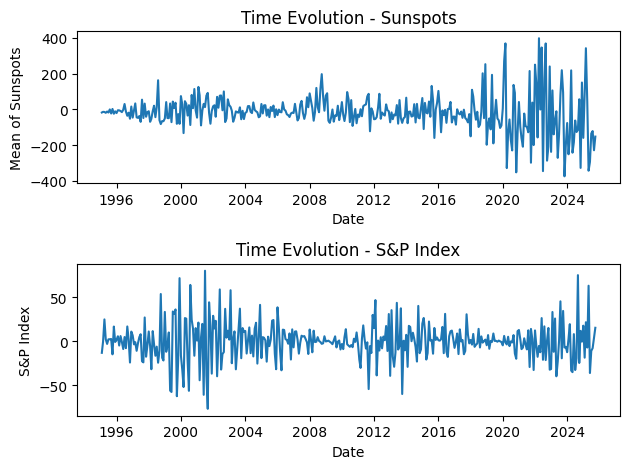

In [24]:
# diferenciando em 1 ordem as variaveis
plt.subplot(2,1,1)
sns.lineplot(data = df_diff, y = 'price_lag1', x = 'date')
plt.title('Time Evolution - Sunspots')
plt.xlabel('Date')
plt.ylabel('Mean of Sunspots')
plt.subplot(2,1,2)
sns.lineplot(data = df_diff, y = 'sunspots_lag1', x = 'date')
plt.title('Time Evolution - S&P Index')
plt.ylabel('S&P Index')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("temporal_evolution_differenced_series.png")

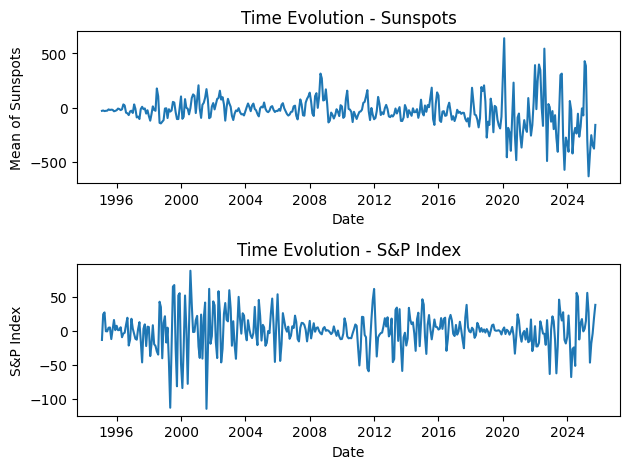

In [25]:
# diferenciando em 2 ordem as variaveis
plt.subplot(2,1,1)
sns.lineplot(data = df_diff, y = 'price_lag2', x = 'date')
plt.title('Time Evolution - Sunspots')
plt.xlabel('Date')
plt.ylabel('Mean of Sunspots')
plt.subplot(2,1,2)
sns.lineplot(data = df_diff, y = 'sunspots_lag2', x = 'date')
plt.title('Time Evolution - S&P Index')
plt.ylabel('S&P Index')
plt.xlabel('Date')
plt.tight_layout()

# (Autocorrelation - Originals and Differenced Series) Autocorrelações - Séries Originais e Diferenciadas

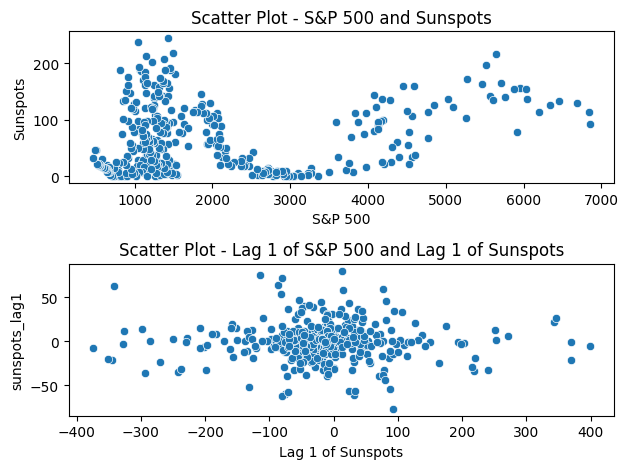

In [26]:
plt.subplot(2,1,1)
sns.scatterplot(data = df_group, x = 'price', y = 'mean_sunspots')
plt.title('Scatter Plot - S&P 500 and Sunspots')
plt.xlabel('S&P 500')
plt.ylabel('Sunspots')
plt.subplot(2,1,2)
sns.scatterplot(data = df_group, x = 'price_lag1', y = 'sunspots_lag1')
plt.title('Scatter Plot - Lag 1 of S&P 500 and Lag 1 of Sunspots')
plt.xlabel('Lag 1 of S&P 500')
plt.xlabel('Lag 1 of Sunspots')
plt.tight_layout()

We do not see a relationship in the scatter plot of the variables.

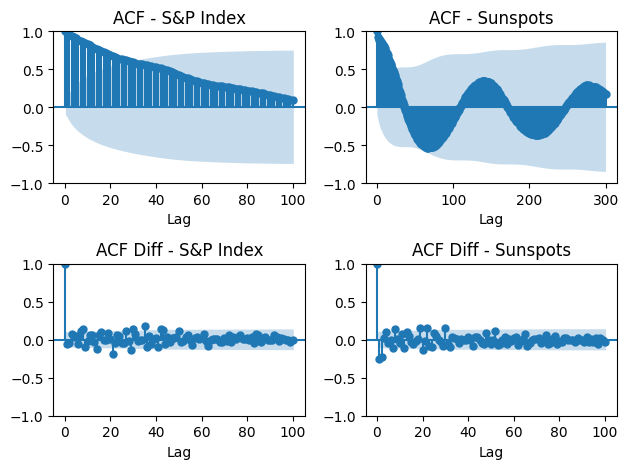

In [27]:
# Autocorrelações

plt.subplot(2,2,1)
plot_acf(df_group['price'], lags=100, ax=plt.gca())
plt.title('ACF - S&P Index')
plt.xlabel('Lag')
plt.subplot(2,2,2)
plot_acf(df_group['mean_sunspots'], lags=300, ax=plt.gca())
plt.title('ACF - Sunspots')
plt.xlabel('Lag')
plt.subplot(2,2,3)
plot_acf(df_diff['price_lag1'], lags=100, ax=plt.gca())
plt.title('ACF Diff - S&P Index')
plt.xlabel('Lag')
plt.subplot(2,2,4)
plot_acf(df_diff['sunspots_lag1'], lags=100, ax=plt.gca())
plt.title('ACF Diff - Sunspots')
plt.xlabel('Lag')
plt.tight_layout()
plt.savefig("autocorrelation_series.png")

# (Analysis of Stationarity of the Series) Analise da Estacionariedade das Séries

Há presença de sazonalidade por volta da lag de número 140 na série de monthly mean sunspots.
Pela diferenciação em 1° ordem, as séries se tornaram estacionárias em torno da média, porém a primeira série possui variância que cresce ao longo do tempo (heterocedasticidade). 
Assim, usaremos um modelo VAR com erros robustos para abranger a heterocedasticidade.

There is seasonality around lag 140 in the monthly mean sunspots series.
By first-order differencing, the series became stationary around the mean. However, the first series exhibits variance that increases over time (heteroscedasticity).
Thus, we will use a VAR model with robust errors to account for heteroscedasticity.


Verificaremos estatisticamente a estacionariedade com teste de Dickey Fuller Aumentado (considera dependências temporais de ordem superior a 1). 

We will check with an Augmented Dickey Fuller (ADF) Test to analyze the stationarity of the series.

$$
H_0: \gamma =0 \text{ (possui uma raiz unitária, logo é estacionária (it does have a unit root, it is stationary)) vs } H_1: \gamma < 0
$$

In [28]:
adfuller(df_group['price'])

(-4.195435150744027,
 0.0006707221804453625,
 14,
 356,
 {'1%': -3.448853029339765,
  '5%': -2.869693115704379,
  '10%': -2.571113512498422},
 4211.269058677322)

In [29]:
adfuller(df_group['mean_sunspots'])

(-3.061248557468174,
 0.029557080809982633,
 15,
 355,
 {'1%': -3.448905534655263,
  '5%': -2.8697161816205705,
  '10%': -2.5711258103550882},
 3081.6057320559257)

In [30]:
adfuller(df_diff['price_lag1'])

(-4.811117205355565,
 5.178438405869227e-05,
 13,
 355,
 {'1%': -3.448905534655263,
  '5%': -2.8697161816205705,
  '10%': -2.5711258103550882},
 4191.326504738938)

In [31]:
print(adfuller(df_diff['sunspots_lag1']))
pp = PhillipsPerron(df_diff['sunspots_lag1'])
print(pp)

(-4.773539794657616, 6.109205852662267e-05, 12, 356, {'1%': -3.448853029339765, '5%': -2.869693115704379, '10%': -2.571113512498422}, 3068.2155746612334)
     Phillips-Perron Test (Z-tau)    
Test Statistic                -28.969
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [32]:
adfuller(df_diff['price_lag2'])

(-4.386408163950467,
 0.00031371184744484075,
 14,
 354,
 {'1%': -3.4489583388155194,
  '5%': -2.869739378430086,
  '10%': -2.5711381780459},
 4212.5138743998705)

In [33]:
print(adfuller(df_diff['sunspots_lag2']))
pp = PhillipsPerron(df_diff['sunspots_lag2'])
print(pp)

(-4.078456587846802, 0.0010510582378726947, 15, 353, {'1%': -3.4490114443793214, '5%': -2.8697627072503757, '10%': -2.5711506161673716}, 3092.125562021099)
     Phillips-Perron Test (Z-tau)    
Test Statistic                -15.829
P-value                         0.000
Lags                               17
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Pelo p-valor para as séries originais, temos que não rejeitamos a hipótese nula ao nível de significância de 5%, logo não são estacionárias. 

Para as séries diferenciadas, ambas obtiveram p-valor baixos, rejeitando a hipótese nula ao nível de significância de 5%. Utilizei, também, o teste de PhillipsPerron para a série de Sunspots pois engloba heterocedasticidade, chegando à mesma conclusão do ADF.

Based on the p-value, the original series are not stationary due we do not reject the null hypothesis. However, for the differenced series, we do reject the null hypothesis at the significance level of 5%. I also used the PhillipsPerron because it supports heterocedasticity and the conclusion is the same.

In [34]:
df_diff.head()

,date,mean_sunspots,price,sunspots_lag1,price_lag1,sunspots_lag2,price_lag2
368,2025-10-01,129.8,6688.46,15.2,-151.74,38.0,-160.63
367,2025-09-01,133.5,6460.26,3.7,-228.20,18.9,-379.94
366,2025-08-01,125.6,6339.39,-7.9,-120.87,-4.2,-349.07
365,2025-07-01,114.6,6204.95,-11.0,-134.44,-18.9,-255.31
364,2025-06-01,78.5,5911.69,-36.1,-293.26,-47.1,-427.70


# (Checking correlation) Verificando correlação entre as variáveis

In [35]:
df_diff.corr()

,date,mean_sunspots,price,sunspots_lag1,price_lag1,sunspots_lag2,price_lag2
date,1.000000,-0.049778,0.850981,-0.002408,-0.147208,-0.002157,-0.213386
mean_sunspots,-0.049778,1.000000,0.167620,0.183748,-0.023579,0.225452,-0.010714
price,0.850981,0.167620,1.000000,-0.011340,-0.158745,-0.015711,-0.232625
sunspots_lag1,-0.002408,0.183748,-0.011340,1.000000,-0.007867,0.611627,0.057566
price_lag1,-0.147208,-0.023579,-0.158745,-0.007867,1.000000,-0.059381,0.688966
sunspots_lag2,-0.002157,0.225452,-0.015711,0.611627,-0.059381,1.000000,0.004040
price_lag2,-0.213386,-0.010714,-0.232625,0.057566,0.688966,0.004040,1.000000


In [36]:
# testando correlação de spearman para capturar além de relação linear

# testing spearman correlation to capture more than the linear relationship

df_diff.corr(method='spearman')

,date,mean_sunspots,price,sunspots_lag1,price_lag1,sunspots_lag2,price_lag2
date,1.000000,-0.040423,0.894640,-0.026932,-0.188212,-0.017235,-0.258563
mean_sunspots,-0.040423,1.000000,0.097777,0.137649,0.019170,0.199296,0.021029
price,0.894640,0.097777,1.000000,-0.023244,-0.143429,-0.019460,-0.191444
sunspots_lag1,-0.026932,0.137649,-0.023244,1.000000,0.017635,0.568593,0.070928
price_lag1,-0.188212,0.019170,-0.143429,0.017635,1.000000,0.013547,0.662288
sunspots_lag2,-0.017235,0.199296,-0.019460,0.568593,0.013547,1.000000,0.012230
price_lag2,-0.258563,0.021029,-0.191444,0.070928,0.662288,0.012230,1.000000


Para as séries estacionárias (diferenciadas) $price\_lag1$ e $sunspots\_lag1$, temos pouquíssima correlação entre as variáveis.

For the stationary series (the differenced ones) $price\_lag1$ and $sunspots\_lag1$, we see a low correlation between them.

Text(0, 0.5, 'Correlação')

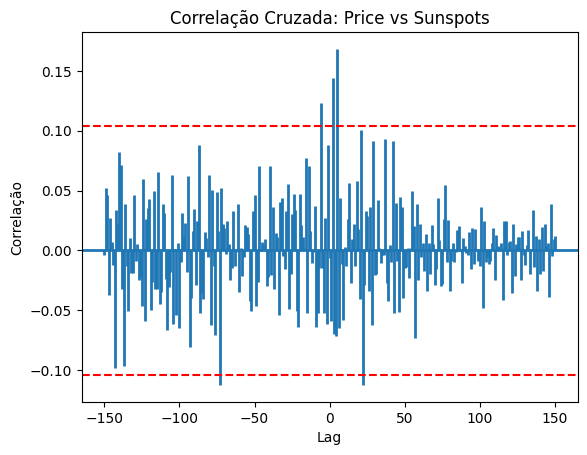

In [37]:
# correlação cruzada com limites

# cross-correlation with limits

lim_upper = 2/np.sqrt(df_diff.shape[0])
lim_lower = -2/np.sqrt(df_diff.shape[0])

fig, ax = plt.subplots()
ax.xcorr(df_diff['price_lag1'], df_diff['sunspots_lag1'], usevlines=True, maxlags=150, normed=True, lw=2)
ax.axhline(y=lim_upper, color='red', linestyle ='--')
ax.axhline(y=lim_lower, color='red', linestyle ='--')
ax.set_title('Correlação Cruzada: Price vs Sunspots')
ax.set_xlabel('Lag')
ax.set_ylabel('Correlação')

Há uma certa correlação entre as séries estacionárias com defasagens pequenas porém são poucos picos e são aleatórios, não sendo uma forte evidência estatística de correlação. Usaremos teste de Granger para entender se há causalidade.

There is some correlation between the stationary series at lower lags, however, these are few peaks and they are random, not being a strong statistical evidence of correlation. We will use Granger-Causality test to assess possible causality.

# (Adjusting Model) Ajustando Modelo - VAR

Usaremos o modelo VAR bivariado para modelar as séries diferenciadas. A forma padrão é, para a ordem p,
$$
\begin{bmatrix}
\Delta y_t \\
\Delta x_t
\end{bmatrix}
= \sum_{i=1}^p \begin{bmatrix}
\alpha_{11,i} & \alpha_{12,i}  \\
\alpha_{21,i} & \alpha_{22,i}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-i} \\
x_{2,t-i}
\end{bmatrix}
+
\begin{bmatrix}
u_{1,t} \\
u_{2,t}
\end{bmatrix}
$$

E consideraremos $u_t$ heterocedástico.

We will use the bivariate VAR model to model the differenced series. The formula of the model is

$$
\begin{bmatrix}
\Delta y_t \\
\Delta x_t
\end{bmatrix}
= \sum_{i=1}^p \begin{bmatrix}
\alpha_{11,i} & \alpha_{12,i}  \\
\alpha_{21,i} & \alpha_{22,i}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-i} \\
x_{2,t-i}
\end{bmatrix}
+
\begin{bmatrix}
u_{1,t} \\
u_{2,t}
\end{bmatrix}
$$

We will considere $u_t$ as heterocedastic.

In [38]:
Y = df_diff[['price_lag1','sunspots_lag1']]
T = df_diff.shape[0]

In [39]:
# Seleção da ordem de diferenciacao

model = VAR(Y)
lag_order = model.select_order(maxlags=10)
print(lag_order.summary())
p = lag_order.bic

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        15.32       15.34   4.495e+06       15.33
1        15.24       15.31   4.175e+06       15.27
2        15.15      15.26*   3.805e+06      15.19*
3        15.14       15.29   3.772e+06       15.20
4        15.16       15.35   3.825e+06       15.23
5        15.15       15.39   3.787e+06       15.24
6        15.15       15.43   3.808e+06       15.26
7        15.12       15.44   3.686e+06       15.25
8        15.12       15.48   3.673e+06       15.26
9       15.11*       15.52  3.656e+06*       15.28
10       15.13       15.58   3.709e+06       15.31
--------------------------------------------------


c:\users\rosan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Vemos que a lag 2 possui os menores índices AIC e BIC, sendo, assim, um modelo que melhor avalia mudanças nas variáveis dependentes.
A métrica AIC não penaliza aumento de variáveis no modelo, enquanto o BIC penaliza. 
Reiterando, a defasagem que apresenta menor BIC é a defasagem 2.

We see that lag 2 has the lowest AIC and BIC values, thus representing the model that best captures changes in the dependent variables.
The AIC metric does not penalize the addiction of variables to the model, whereas BIC does.


In [40]:
# Ajustando VAR(2)

res = model.fit(p)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Dec, 2025
Time:                     17:34:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.3663
Nobs:                     367.000    HQIC:                   15.3022
Log likelihood:          -3831.70    FPE:                4.23939e+06
AIC:                      15.2599    Det(Omega_mle):     4.12620e+06
--------------------------------------------------------------------
Results for equation price_lag1
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                  -17.852616         5.516391           -3.236           0.001
L1.price_lag1           -0.051741         0.051749           -1.000           0.317
L1.sunspots_lag1        -0.093573         0

Vemos que, para explicar a variável price_lag1, apenas a variável sunspots_lag1 com lag 2 foi significante para o modelo, obtendo um p-valor de 1%.
Como há heterocedasticidade, reamostraremos os dados para refazer o modelo a fim de realizar uma inferência mais robusta.

To explain the price_lag1 variable, the only signifficant coefficient in the model is sunspots_lag1 at the 2° lag with a p-value of 1%. 
Since there is heterocedasticity, we will resample the data to refit the model, allowing for more robust inference.

In [41]:
# testando causalidade se a lag 1 de sunspots causa a lag 1 em price

res.test_causality('price_lag1', ['sunspots_lag1'], kind='f').summary()

Test statistic,Critical value,p-value,df
3.796,3.008,0.023,"(2, 724)"


Pelo p-valor, rejeitamos a hipótese nula de que a lag 1 de sunspots não causa a lag 1 de price e, assim, temos evidências, pelos dados, de que há causalidade de sunspots_lag1 para price_lag1.
Based on the p-value, we do not reject the null hypothesis that the lag 1 of sunspots does not cause the lag 1 of price and, thus, we have evidence from the data that there is not causality from sunspots_lag1 to price_lag1.

In [42]:
res.test_causality('sunspots_lag1',['price_lag1'],kind='f').summary()

Test statistic,Critical value,p-value,df
1.243,3.008,0.289,"(2, 724)"


Corroborando o senso comum, pelo p-valor, não rejeitamos a hipótese nula de que a lag 1 de price não causa a lag 1 de sunspots e, assim, temos evidências, pelos dados, de que não há causalidade de price_lag1 para sunspots_lag1.
Assim, não há causalidade bilateral. Pelo bootstrap, verificaremos os p-valores para entender se a relação é válida em todos os modelos testados.

Supporting the common sense, based on the p-value, we do not reject the null hypothesis that the lag 1 of price does not cause the lag 1 of sunspots and, thus, we have evidence from the data that there is not causality from price_lag1 to sunspots_lag1.
As a result, there is not bilateral causality. By the bootstrap method, we will see the p-values to assess whether this conclusion holds.

# (Heterocedasticity Diagnosis) Diagnóstico de Heterocedasticidade

Sob $H_0$ temos que $\alpha_i = 0$ para todo $i=1,...,p$ (não há efeito ARCH, ou seja, é homocedástico) e segue uma qui-quadrado com $p$ graus de liberdade. Então, neste caso

$$
H_0:\alpha_i = 0 \text{ para todo }i=1,...,p \text{ vs }H_1: \alpha_i \neq 0 \text{ para, ao menos, um }i 
$$

$$
T \sim \chi^2_2
$$

Verificaremos as estatísticas das séries diferenciadas e compararemos com o quantil crítico de 95%.

Under $H_0$, we have $\alpha_i = 0$ for all $i=1,...,p$ (there is not ARCH effect, i.e., it is homocedastic) and it follows a chi-squared distribution with $p$ degrees of freedom. In this case

$$
H_0:\alpha_i = 0 \text{ for all }i=1,...,p \text{ vs }H_1: \alpha_i \neq 0 \text{ for, at least, a }i 
$$

$$
T \sim \chi^2_2
$$

In [43]:
# Diagnosticando heterocedasticidade 

for col in Y.columns:
    stat, pval, _, _ = het_arch(res.resid[col])
    print(f"{col}: p-valor ARCH = {pval} e estatística de teste = {stat}")


price_lag1: p-valor ARCH = 3.982042363790098e-20 e estatística de teste = 115.57895882818394
sunspots_lag1: p-valor ARCH = 3.146256281478309e-07 e estatística de teste = 49.6113079299631


Não foi necessário obter o quantil crítico, as estatísticas de teste são bem altas, rejeitando, assim, $H_0$ sob um nível de significância relevante. 
Assim, ambas as séries são heterocedásticas e, portanto, será utilizado o método Bootstrap pois é robusto à heterocedasticidade.

It was not necessary to obtain the critical quantile since the test statistics are both large values, rejecting, thus, $H_0$ at a relevant significance level.
Therefore, both series are heterocedastics and the bootstrap method will be used because it is robust to heterocedasticity. 

# (Bootstrap Method to Obtain Statistics) Bootstrap para Obter Estatísticas

In [44]:
    # obtendo estatísticas com Bootstrap (via reamostragem)
    # Para cada iteração do bootstrap, realiza o VAR bivariado e obtem estatísticas do modelo para, ao fim, realizar inferência robusta sobre os coeficientes

    def bootstrap_var(n_iter, res, seed=123):
        np.random.seed(seed)

        # dimensões
        T,K = Y.shape
        # defasagem do modelo
        p = res.k_ar
        # parametros do var
        coef = res.params.index 
        # numero de parametros
        n_coef = res.params.shape[0]

        series_names = Y.columns
        p_values_boot = {f'{Y.columns[y1]} -> {Y.columns[y2]}': [] for y1 in range(K) for y2 in range(K) if y1 != y2}

        coef_boot = np.zeros((n_iter,n_coef))
        fitted = res.fittedvalues.values
        residuals = res.resid.values

        # AIC and BIC
        aic = []
        bic = []

        coefs_metric = []
        cont = 0
        for i in range(n_iter):
            e = choice([-1,1], size=T-p)

            Y_star = Y.values.copy()
            for t in range(p,T):
                Y_star[t] = fitted[t-p] + residuals[t-p]*e[t-p]

            var_star = VAR(Y_star).fit(p)
            coef_boot[i,:] = var_star.params[:,0]

            # AIC and BIC
            aic.append(var_star.aic)
            bic.append(var_star.bic)

            # Testar causalidade de Granger para todos os pares de variáveis
            for j in range(K):
                for k in range(K):
                    if j == k:  # Não testamos causalidade de uma variável sobre ela mesma
                        continue

                    # Realizando o teste de causalidade de Granger (k -> j)
                    causality_test = var_star.test_causality(k, j, kind='f')
                    p_val = causality_test.pvalue  # Valor-p do teste

                    # Armazenando os resultados de causalidade para cada par de variáveis
                    pair_key = f'{Y.columns[j]} -> {Y.columns[k]}'  # Chave para identificar o par de variáveis
                    p_values_boot[pair_key].append(p_val)

        return coef_boot, coef, p_values_boot, (aic,bic)

In [45]:
n_iter = 5000

coefs_bootstrap, coefs, pvals_causality, aic_bic_metr = bootstrap_var(n_iter, res = res, seed = 123)

# (Checking Quality of Adjusted Metrics) Verificando Métricas de Qualidade de Ajuste

C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\531493142.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(aic, shade=True)
C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\531493142.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(bic, shade=True)


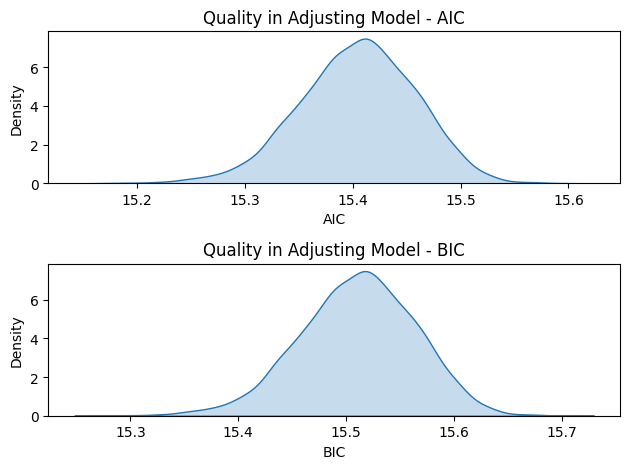

In [46]:
aic = aic_bic_metr[0]
bic = aic_bic_metr[1]

plt.subplot(2,1,1)
sns.kdeplot(aic, shade=True)
plt.title('Quality in Adjusting Model - AIC')
plt.xlabel('AIC')
plt.ylabel('Density')
plt.subplot(2,1,2)
sns.kdeplot(bic, shade=True)
plt.title('Quality in Adjusting Model - BIC')
plt.ylabel('Density')
plt.xlabel('BIC')
plt.tight_layout()

As métricas BIC e AIC não se mostraram inconsistentes ao longos dos modelos testados.

The BIC and AIC metrics are not inconsistent across the models tested. 

# (Checking Causality) Verificando Causalidade

C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\3155831713.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pvals1, shade=True)
C:\Users\rosan\AppData\Local\Temp\ipykernel_13404\3155831713.py:26: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pvals2, shade=True)


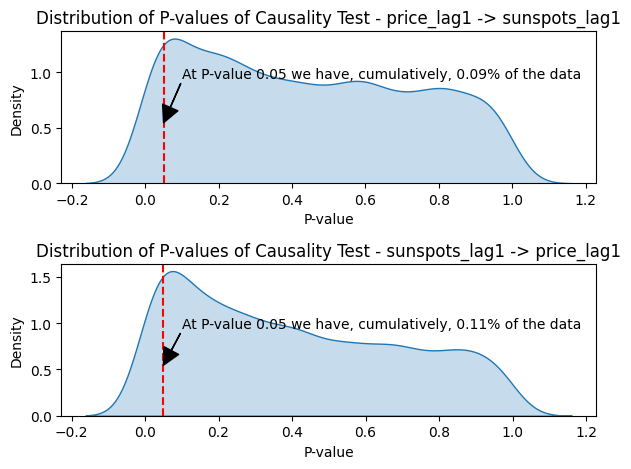

In [47]:
y1 = 'price_lag1'
y2 = 'sunspots_lag1'

# cdf (cumulative distribution function) of p-values
pvals1 = list(pvals_causality[f'{y1} -> {y2}'])
pvals1.sort()
pvals2 = list(pvals_causality[f'{y2} -> {y1}'])
pvals2.sort()
cdf1 = np.arange(1, len(pvals1)+ 1)/len(pvals1)
cdf2 = np.arange(1, len(pvals2)+ 1)/len(pvals2)

# getting the closest p-value of 0.05
df_cdf1 = pd.DataFrame({'p-value':pvals1,'cdf':cdf1})
df_cdf1['diff'] = np.abs(df_cdf1['p-value'] - 0.05)
df_cdf2 = pd.DataFrame({'p-value':pvals2,'cdf':cdf2})
df_cdf2['diff'] = np.abs(df_cdf2['p-value'] - 0.05)

plt.subplot(2,1,1)
sns.kdeplot(pvals1, shade=True)
plt.axvline(x = 0.05, color='red', linestyle='--')
plt.annotate(f"At P-value 0.05 we have, cumulatively, {round(df_cdf1.loc[df_cdf1['diff'].idxmin()]['cdf'],2)}% of the data", xy=(0.05,0.545), xytext=(0.1,0.95),arrowprops=dict(facecolor='black', width=0.2),)
plt.title(f'Distribution of P-values of Causality Test - {y1} -> {y2}')
plt.xlabel('P-value')
plt.ylabel('Density')
plt.subplot(2,1,2)
sns.kdeplot(pvals2, shade=True)
plt.title(f'Distribution of P-values of Causality Test - {y2} -> {y1}')
plt.axvline(x = 0.05, color='red', linestyle='--')
plt.annotate(f"At P-value 0.05 we have, cumulatively, {round(df_cdf2.loc[df_cdf2['diff'].idxmin()]['cdf'],2)}% of the data", xy=(0.05,0.545), xytext=(0.1,0.95),arrowprops=dict(facecolor='black', width=0.2),)
plt.ylabel('Density')
plt.xlabel('P-value')
plt.tight_layout()

# (Causality Hypothesis) Hipótese de Causalidade

$$
H_0: \text{Variable does not cause the other vs }H_1: \text{Variable does cause the other}
$$

Como vemos acima, os p-valores dos testes de causalidade são bem distribuídos ACIMA de 0,05% para ambas as séries. Temos uma proporção pequena (9% e 11%) de testes para os quais rejeitamos $H_0$, ou seja, para 91% e 89% dos testes, não rejeitamos $H_0$ e, assim, há evidências estatísticas de que não há causalidade entre as variáveis testadas.

As we see in the plots, the p-values of the causality tests are well distributed ABOVE 0,05% for both the series. We have a small proportion (9% and 11%) of tests that we do reject $H_0$, i.e., for 91% and 89% of the tests, we do not reject $H_0$ and, hence, there is statistical evidence of a non-causality between the tested variables.

# (Confidence Interval for Coefficients) Intervalos de Confiança dos Coeficientes

In [48]:
coefs_names = res.params.index
c = 0

for coef in coefs_names:
    print(f'Confidence Interval of 95% for {coef}:')
    print(np.quantile(coefs_bootstrap[:,c],[0.025,0.975]))
    print('\n')
    c += 1

Confidence Interval of 95% for const:
[-28.62862379  -5.46648055]


Confidence Interval of 95% for L1.price_lag1:
[-0.18240062  0.15781674]


Confidence Interval of 95% for L1.sunspots_lag1:
[-0.66770495  0.26603058]


Confidence Interval of 95% for L2.price_lag1:
[-0.18406335  0.15973476]


Confidence Interval of 95% for L2.sunspots_lag1:
[-0.43478441  0.63160909]




# (Marginal Density of the Coefficients) Densidade Marginal dos Coeficientes

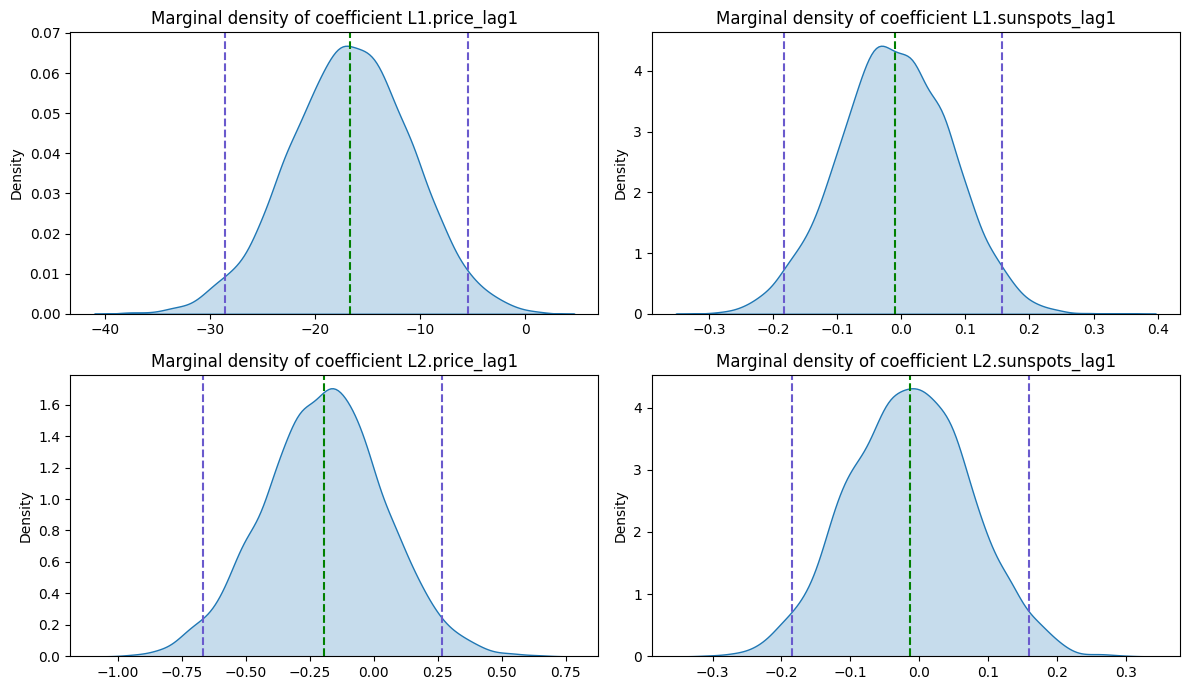

<Figure size 640x480 with 0 Axes>

In [49]:
plt.figure(figsize=(12,7))

coefs_names = res.params.index[1:]
c = 0

for coef in coefs_names:
    plt.subplot(2,2,c+1)
    sns.kdeplot(coefs_bootstrap[:,c], fill=True)
    plt.title(f"Marginal density of coefficient {coef}")
    h1=plt.axvline(x = np.mean(coefs_bootstrap[:,c]),label='Mean',linestyle='--',color='green')
    h2=plt.axvline(x = np.quantile(coefs_bootstrap[:,c],0.025),label='CI 2,5%',linestyle='--',color='slateblue')
    h3=plt.axvline(x = np.quantile(coefs_bootstrap[:,c],0.975),label='CI 97,5%',linestyle='--',color='slateblue')
    c += 1

plt.tight_layout()
plt.show()
plt.savefig("marginal_density_coef.png")

In [50]:
# dataframe com as estatísticas

coefs_metrics = []
coef_names = res.params.index

for c in range(len(coef_names)):
    mean_coef = np.mean(coefs_bootstrap[:,c])
    std_coef = np.std(coefs_bootstrap[:,c])
    ci_lower = np.quantile(coefs_bootstrap[:,c],0.025)
    ci_upper = np.quantile(coefs_bootstrap[:,c],0.975)

    coefs_metrics.append((coef_names[c],mean_coef,std_coef,ci_lower,ci_upper))
df_boot = pd.DataFrame(coefs_metrics, columns=['Coefficient','Mean','STD','CI 2.5%','CI 97.5%'])
df_boot

,Coefficient,Mean,STD,CI 2.5%,CI 97.5%
0,const,-16.688183,5.843615,-28.628624,-5.466481
1,L1.price_lag1,-0.010207,0.087020,-0.182401,0.157817
2,L1.sunspots_lag1,-0.195604,0.234539,-0.667705,0.266031
3,L2.price_lag1,-0.013544,0.087691,-0.184063,0.159735
4,L2.sunspots_lag1,0.112086,0.274972,-0.434784,0.631609


In [51]:
non_significant = df_boot[(df_boot['CI 2.5%'] < 0) & (df_boot['CI 97.5%'] > 0)]
non_significant

,Coefficient,Mean,STD,CI 2.5%,CI 97.5%
1,L1.price_lag1,-0.010207,0.087020,-0.182401,0.157817
2,L1.sunspots_lag1,-0.195604,0.234539,-0.667705,0.266031
3,L2.price_lag1,-0.013544,0.087691,-0.184063,0.159735
4,L2.sunspots_lag1,0.112086,0.274972,-0.434784,0.631609


In [52]:
significant = df_boot[(df_boot['CI 2.5%'] > 0) | (df_boot['CI 97.5%'] < 0)]
significant

,Coefficient,Mean,STD,CI 2.5%,CI 97.5%
0,const,-16.688183,5.843615,-28.628624,-5.466481


As métricas acima mostram que os coeficientes podem não ser significantes para os modelos, corroborando a ideia de não causalidade.

The metrics above show that the coefficients may not be significant for the tested models, supporting the idea of non-causality.

# Conclusion

We modeled the difference in S&P 500 Index (named as price_lag1) against the difference in monthly mean sunspots (named as sunspots_lag1) and our conclusion is that there is neither correlation and causality between them, i.e., the difference in in monthly mean sunspots does not affect significantly the differente in S&P 500 Index. Therefore, I would not allocate capital to this signal.

# Plus: Modelling the Monthly Mean Sunspots

We can model the monthly mean sunspots with periodic functions (sin and cos).

In [53]:
# Discretizando o intervalo dos meses no eixo X
# Discretizing the interval of months on the X-axis

df_sun['month'] = [i for i in range(df_sun.shape[0])]
sunspots = df_sun['mean_sunspots']

In [54]:
df_sun.shape

(371, 3)

<Axes: xlabel='month', ylabel='mean_sunspots'>

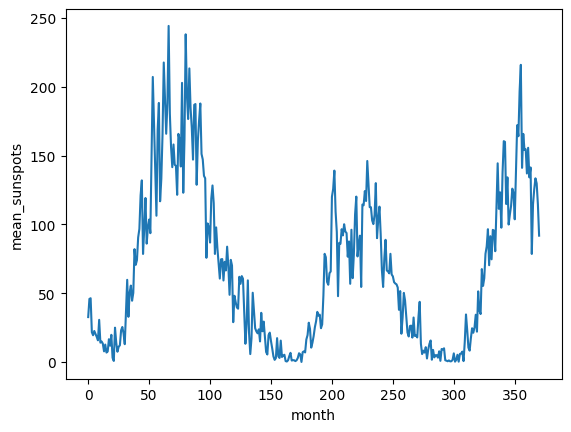

In [55]:
sns.lineplot(data = df_sun, x = 'month', y = 'mean_sunspots')

Considere a função 

$$
f(t)=a_0+a_1\cos(a_3t)+a_2\sin(a_4t)
$$

como modelo para a distribuição, usaremos o método dos gradientes descendentes com as seguintes especificações:

$$t\in[0,2\pi]\\
\begin{array}{rl}
n & = & 50000 \quad \mbox{(número de passos no método)}\\
h & = & 10^{-7} \quad \mbox{(tamanho do passo )}\\
[a^0_0,a^0_1,a^0_2,a^0_3,a^0_4] & = &[1,1,1,1,1] \quad \mbox{(condição inicial)}
\end{array}
$$

Consider the function

$$
f(t)=a_0+a_1\cos(a_3t)+a_2\sin(a_4t)
$$

As the model for the distribution, we will use the descendent gradient method with specifications:

$$t\in[0,2\pi]\\
\begin{array}{rl}
n & = & 50000 \quad \mbox{(número de passos no método)}\\
h & = & 10^{-7} \quad \mbox{(tamanho do passo )}\\
[a^0_0,a^0_1,a^0_2,a^0_3,a^0_4] & = &[1,1,1,1,1] \quad \mbox{(condição inicial)}
\end{array}
$$

Minimizando erro/Minimizing error:
$$E = \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)^2}$$
Temos o gradiente/The gradient is:
$$\frac{dE}{da_0} = 2 \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)}$$
$$\frac{dE}{da_1} = 2 \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)(cos(a_3 . t))}$$
$$\frac{dE}{da_2} = 2 \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)(sin(a_4 . t))}$$
$$\frac{dE}{da_3} = 2 \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)(-t . sin(a_3 . t))}$$
$$\frac{dE}{da_4} = 2 \sum{(a_0 + a_1 . cos(a_3 . t) + a_2 . sin(a_4 . t) - Y)(t.cos(a_4 . t))}$$

In [56]:
# Definindo o gradiente
# Defining the gradient
def grad(a, t, y):
    de_a0 = 2*(a[0] + a[1]*np.cos(a[3]*t) + a[2]*np.sin(a[4]*t) - y)
    de_a0 = np.sum(de_a0)
    
    de_a1 = 2*(a[0] + a[1]*np.cos(a[3]*t) + a[2]*np.sin(a[4]*t) - y)*(np.cos(a[3]*t))
    de_a1 = np.sum(de_a1)
    
    de_a2 = 2*(a[0] + a[1]*np.cos(a[3]*t) + a[2]*np.sin(a[4]*t) - y)*(np.sin(a[4]*t))
    de_a2 = np.sum(de_a2)
    
    de_a3 = 2*(a[0] + a[1]*np.cos(a[3]*t) + a[2]*np.sin(a[4]*t) - y)*(-t*np.sin(a[3]*t))
    de_a3 = np.sum(de_a3)
    
    de_a4 = 2*(a[0] + a[1]*np.cos(a[3]*t) + a[2]*np.sin(a[4]*t) - y)*(t*np.cos(a[4]*t))
    de_a4 = np.sum(de_a4)
    
    return np.array([de_a0, de_a1, de_a2, de_a3, de_a4])

In [ ]:
t = np.linspace(0, 2*np.pi, sunspots.size)

# Numero de passos
# Number of iterations
n = 50000
h = 10**(-7)
sunspots_model = np.zeros((5,n))
sunspots_model[:, 0] = [1,1,1,1,1]

for i in range(1, n):
    sunspots_model[:, i] = sunspots_model[:, i-1] - h*grad(sunspots_model[:,i-1], t, sunspots)

print(sunspots_model[:,n-1])

In [ ]:
a = sunspots_model[:,-1]
df_sun['pred'] = a[0] + a[1] * np.cos(a[3]*t) + a[2] * np.sin(a[4]*t)

In [ ]:
sns.lineplot(data = df_sun, x = 'month', y = 'mean_sunspots')
sns.lineplot(data = df_sun, x ='month', y = 'pred', color = 'red')

In [ ]:
#Predição futura para os próximos 60 meses

# Future prediction for the next 60 months
t_pred = np.linspace(2*np.pi, 2*np.pi + 120*np.pi/365, 61)

sns.lineplot(data = df_sun, x = 'month', y = 'mean_sunspots')
sns.lineplot(data = df_sun, x ='month', y = 'pred', color = 'red')
sns.lineplot(x = range(df_sun.shape[0], df_sun.shape[0]+61), y = a[0] + a[1] * np.cos(a[3]*t_pred) + a[2] * np.sin(a[4]*t_pred), color = 'orange')
plt.savefig("prediction_sunspots_series.png")